In [1]:
import sys
sys.path.append('../30_data_tools/')

In [2]:
import pandas as pd
from pathlib import Path
import sqlite3
from tqdm.auto import tqdm
import plotly.express as px
import json

In [3]:
from helper import load_dotenv
from get_labelstudio_data import get_results_of_project

In [4]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [5]:
masks = pd.merge(
    pd.read_sql(
        '''
            SELECT m.*, gi.timestamp FROM mask m
            LEFT JOIN generic_image gi
            ON
                m.job=gi.job AND
                m.pdf_filename=gi.pdf_filename AND
                m."type"=gi."type" AND
                m.variant_name=gi.variant_name AND
                m.method=gi.method AND
                m.idx=gi.idx
        ''',
        con,
        parse_dates='timestamp'
    ),
    pd.DataFrame(
        [
            (r['id'],r['labels'][0])
            for r in get_results_of_project(2)
            if 'id' in r
        ],
        columns=['mask_id','label']
    ),
    how='left',
    on='mask_id'
)

masks.loc[
    masks.ssim > 0.95,
    'label'
] = 'checked_no_moire'

masks = masks.loc[
    pd.isna(masks.label) == False
]

# Allgemeine Moiré-Quote

In [6]:
masks.loc[masks.label == 'checked_moire'].shape[0] / masks.shape[0]

0.10656574247320973

In [7]:
masks.loc[masks.label == 'checked_moire'].shape[0]

1253

In [8]:
masks_total = pd.read_sql(
    '''
        SELECT m.*, gi.timestamp FROM mask m
        LEFT JOIN generic_image gi
        ON
            m.job=gi.job AND
            m.pdf_filename=gi.pdf_filename AND
            m."type"=gi."type" AND
            m.variant_name=gi.variant_name AND
            m.method=gi.method AND
            m.idx=gi.idx
    ''',
    con,
    parse_dates='timestamp'
)

In [9]:
grouped_by_time_total = masks_total.loc[
    :,
    ['timestamp','mask_id']
].groupby([
    pd.Grouper(key="timestamp", freq="d")
]).count().rename(columns={'mask_id':'anzahl_total'})
grouped_by_time_total.loc[:,'anzahl_exceeded'] = masks_total.loc[
    masks_total.ssim > 0.95,
    ['timestamp','mask_id']
].groupby([
    pd.Grouper(key="timestamp", freq="d")
]).count().mask_id

grouped_by_time_total.loc[:,'exceeded_ratio'] = (grouped_by_time_total.anzahl_exceeded / grouped_by_time_total.anzahl_total).fillna(0)

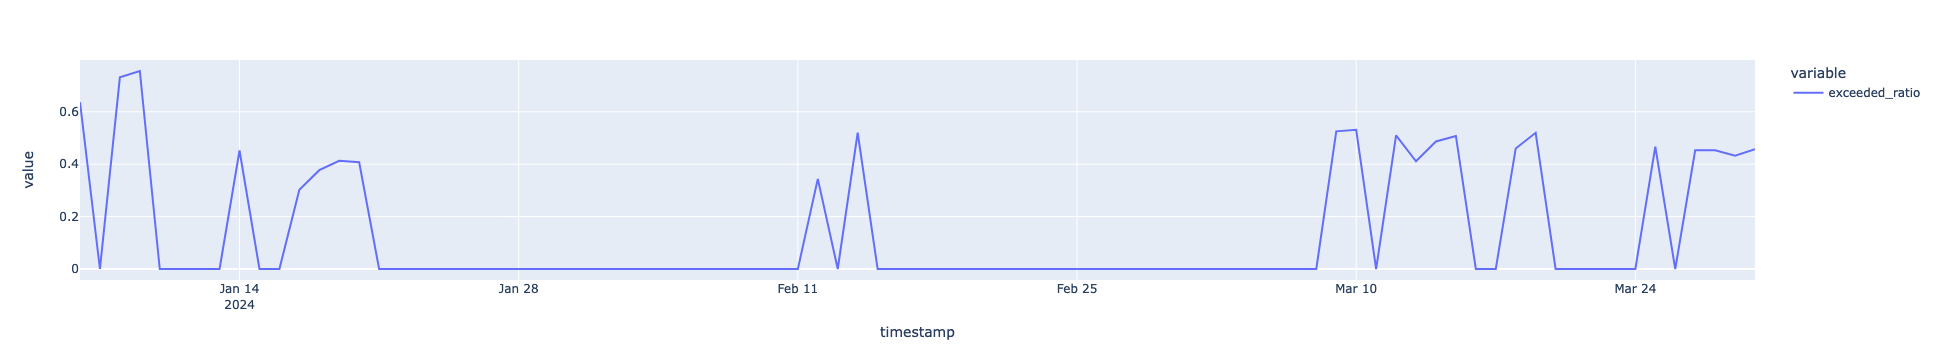

In [10]:
px.line(
    grouped_by_time_total.exceeded_ratio
)

# Entwicklung über Zeit

In [11]:
grouped_by_time = masks.loc[
    :,
    ['mask_id','timestamp','label']
].groupby([
    pd.Grouper(key="timestamp", freq="d"),
    'label'
]).count().unstack('label')
grouped_by_time.columns = [c[1] for c in grouped_by_time.columns]
grouped_by_time.fillna(0, inplace=True)
grouped_by_time.loc[:,'moire_ratio'] = grouped_by_time.checked_moire / (grouped_by_time.checked_moire + grouped_by_time.checked_no_moire)

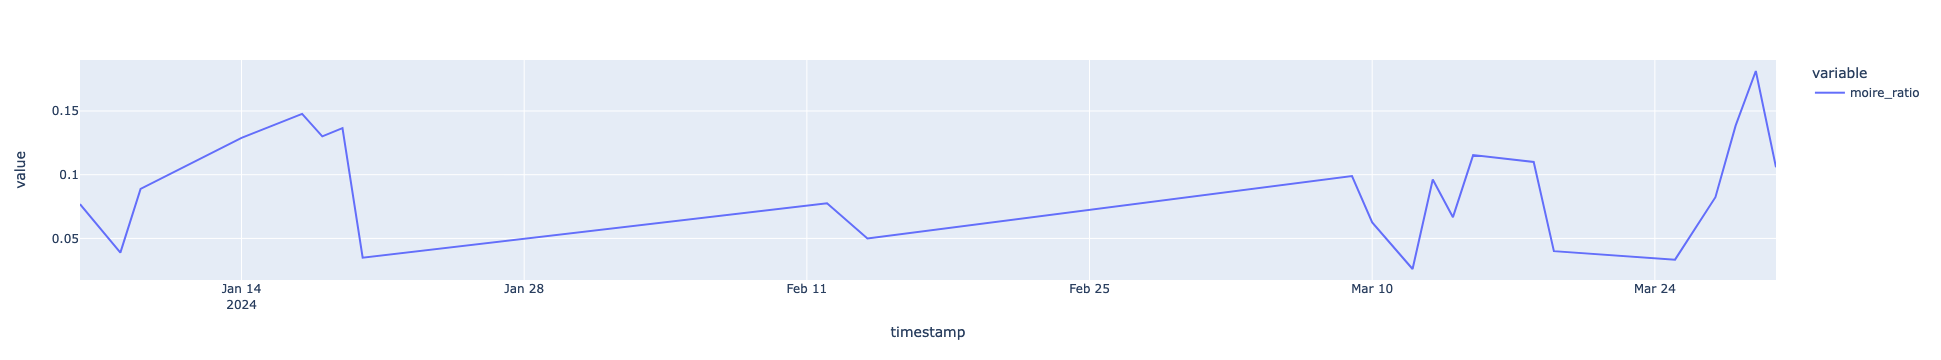

In [12]:
px.line(
    grouped_by_time.moire_ratio
)

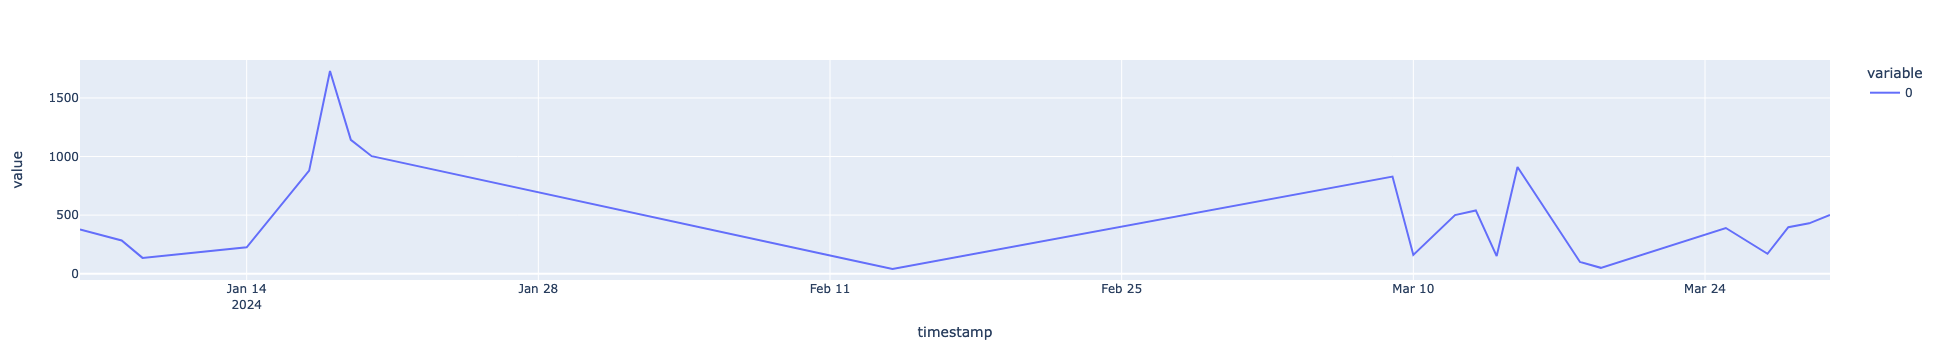

In [13]:
px.line(
    (grouped_by_time.checked_moire + grouped_by_time.checked_no_moire)
)

# Gruppiert nach k-mean-coverage

In [14]:
masks.loc[
    :,
    'K_mean_coverage_centered'
] = (masks.K_mean_coverage - 0.5).abs()

In [15]:
masks_selection = masks.loc[pd.isna(masks.K_std_coverage) == False]

In [16]:
masks_selection.loc[
    :,
    ['ssim','K_mean_coverage','K_mean_coverage_centered','K_std_coverage']
].corr('spearman').loc['ssim']

ssim                        1.000000
K_mean_coverage            -0.468748
K_mean_coverage_centered    0.512749
K_std_coverage             -0.013041
Name: ssim, dtype: float64

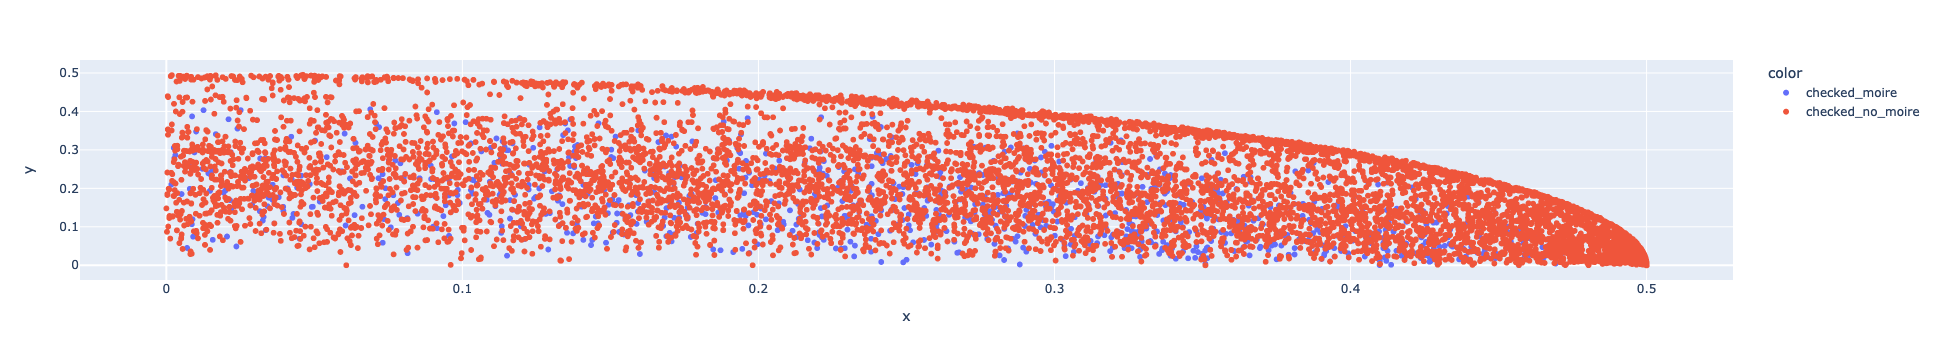

In [17]:
px.scatter(
    x=masks_selection.K_mean_coverage_centered,
    y=masks_selection.K_std_coverage,
    color=masks_selection.label
)

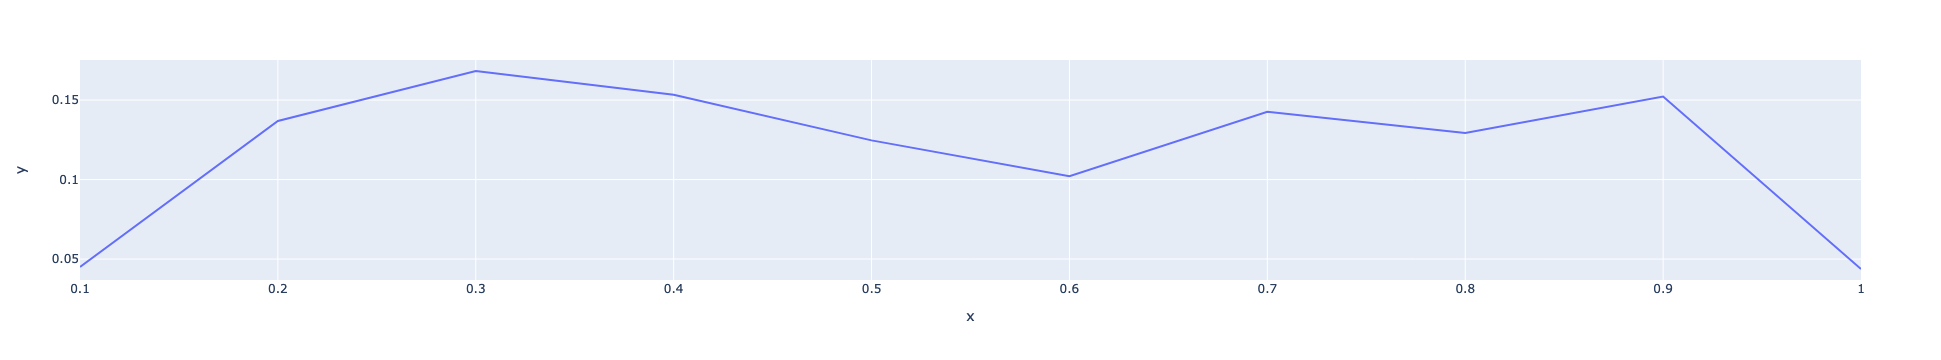

In [18]:
tuples = []

for i in range(10):
    min_coverage = i / 10
    max_coverage = (i+1) / 10

    selection = masks.loc[
        (masks['K_mean_coverage'] >= min_coverage) &
        (masks['K_mean_coverage'] < max_coverage)
    ]
    no_moire_count = selection[selection.label == 'checked_no_moire'].shape[0]
    moire_count = selection[selection.label == 'checked_moire'].shape[0]
    moire_rate = moire_count / (moire_count+no_moire_count)
    
    tuples.append((max_coverage, moire_rate))

px.line(
    x=[t[0] for t in tuples],
    y=[t[1] for t in tuples]
)

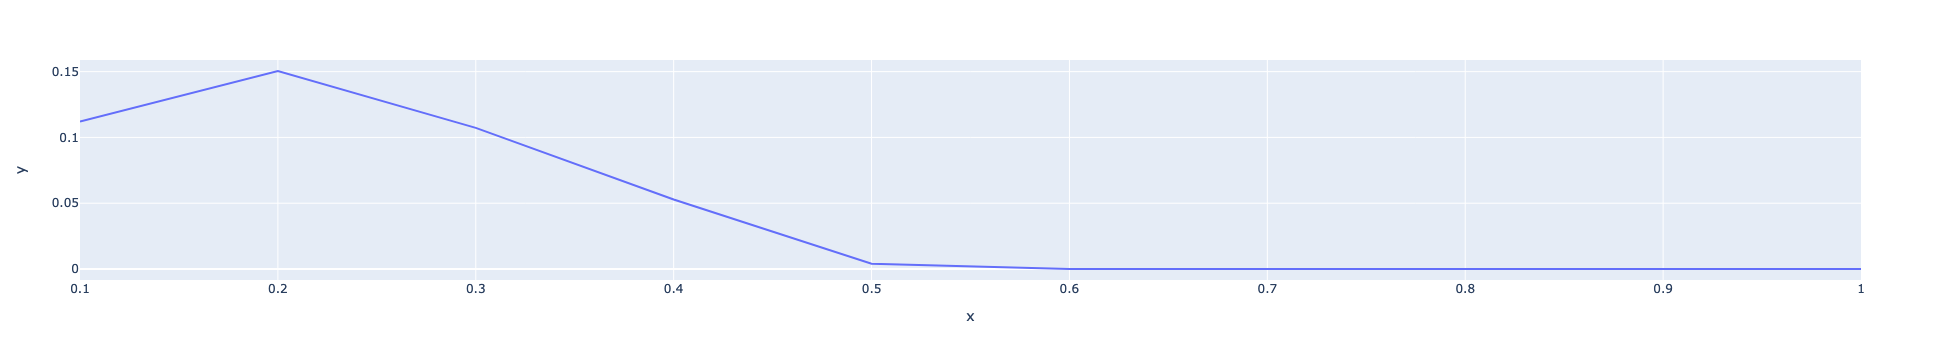

In [20]:
tuples = []

for i in range(10):
    min_std = i / 10
    max_std = (i+1) / 10

    selection = masks.loc[
        (masks['K_std_coverage'] >= min_std) &
        (masks['K_std_coverage'] < max_std)
    ]
    no_moire_count = selection[selection.label == 'checked_no_moire'].shape[0]
    moire_count = selection[selection.label == 'checked_moire'].shape[0]
    if (moire_count+no_moire_count) > 0:
        moire_rate = moire_count / (moire_count+no_moire_count)
    else:
        moire_rate = 0
        
    tuples.append((max_std, moire_rate))

px.line(
    x=[t[0] for t in tuples],
    y=[t[1] for t in tuples]
)

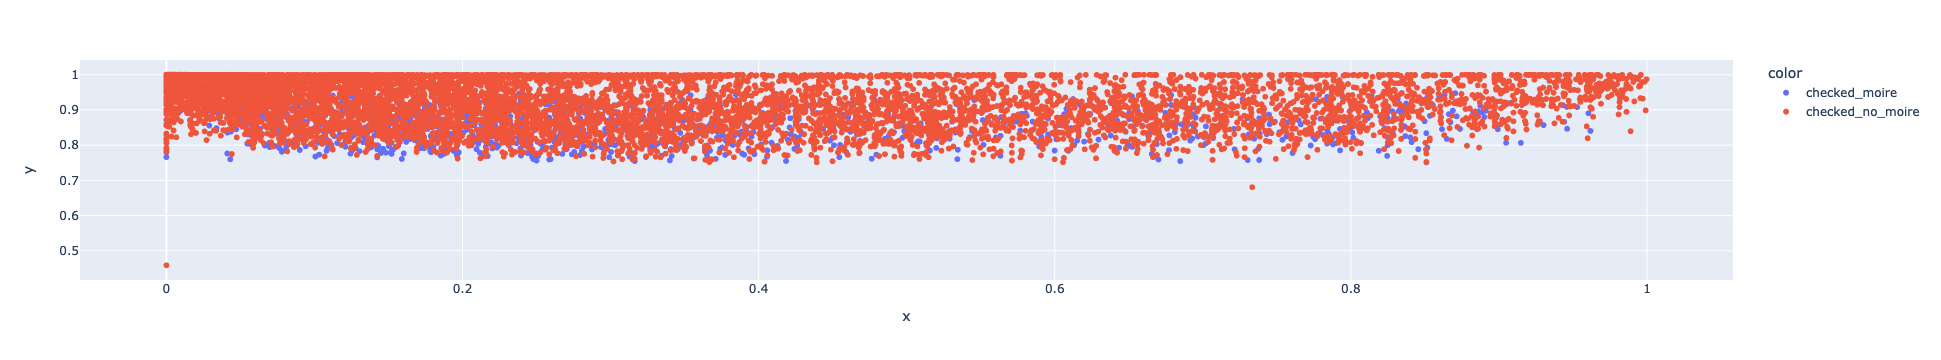

In [21]:
px.scatter(
    y=masks.ssim,
    x=masks['K_mean_coverage'],
    color=masks.label
)

# Gruppiert nach Pattern

In [24]:
grouped_by_pattern = masks.loc[
    (masks.ssim < 0.95),
    ['pattern','label','pdf_filename']
].groupby(['pattern','label']).count().unstack('label')
grouped_by_pattern.columns = [c[1] for c in grouped_by_pattern.columns]
grouped_by_pattern.checked_moire.fillna(0, inplace=True)
grouped_by_pattern.checked_no_moire.fillna(0, inplace=True)
grouped_by_pattern.loc[:,'moire_ratio'] = grouped_by_pattern.checked_moire / (grouped_by_pattern.checked_moire + grouped_by_pattern.checked_no_moire)

In [26]:
grouped_by_pattern.sort_values('moire_ratio', ascending=False)

checked_moire  checked_no_moire  \
pattern                                                                    
perlin_noise.5.33.4.df1;01.LINE                    3.0               2.0   
perlin_noise.5.33.8.df1;1.CIRCLE                   6.0               6.0   
perlin_noise.5.33.19.df1;01.LINE                   6.0               6.0   
plain_4.LINE                                       5.0               6.0   
perlin_noise.5.33.30.df1;01.DIAMOND                5.0               7.0   
...                                                ...               ...   
perlin_noise.5.33.5.df1;01.LINE                    0.0               9.0   
perlin_noise.5.33.4.df1;1.CIRCLE                   0.0               8.0   
plain_8.DIAMOND                                    0.0              14.0   
perlin_noise.5.33.4.df1;01.150pli.linie            0.0              23.0   
plain_9.LINE                                       0.0               5.0   

                                         moire_ratio  
pattern                                               
perlin_noise.5.33.4.df1;01.LINE             0.600000  
perlin_noise.5.33.8.df1;1.CIRCLE            0.500000  
perlin_noise.5.33.19.df1;01.LINE            0.500000  
plain_4.LINE                                0.454545  
perlin_noise.5.33.30.df1;01.DIAMOND         0.416667  
...                                              ...  
perlin_noise.5.33.5.df1;01.LINE             0.000000  
perlin_noise.5.33.4.df1;1.CIRCLE            0.000000  
plain_8.DIAMOND                             0.000000  
perlin_noise.5.33.4.df1;01.150pli.linie     0.000000  
plain_9.LINE                                0.000000  

[148 rows x 3 columns]

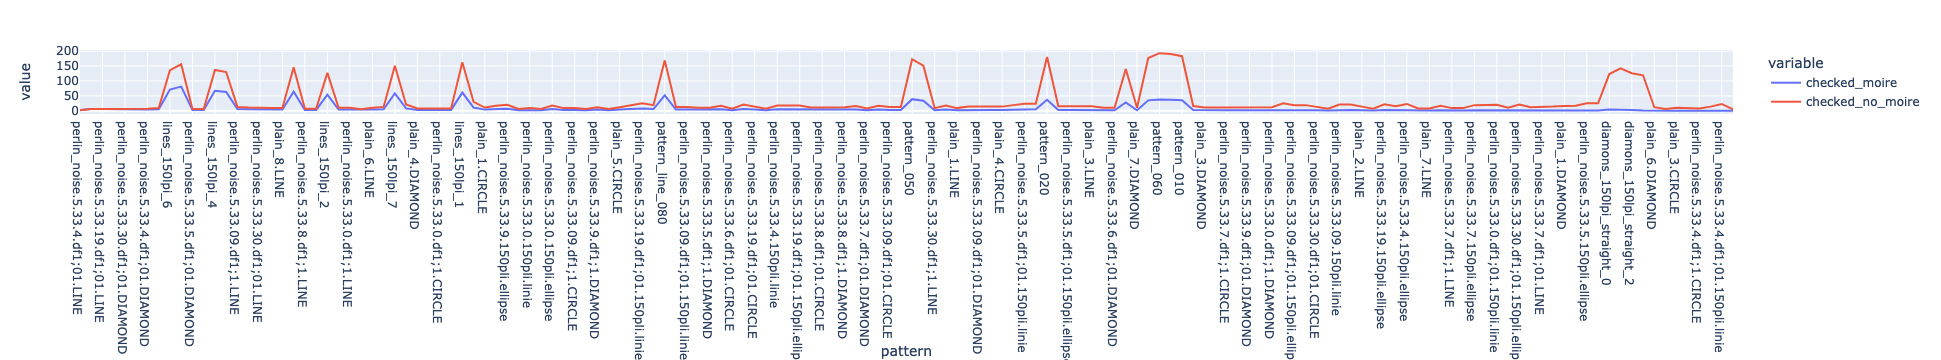

In [29]:
px.line(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False).loc[:,['checked_moire','checked_no_moire']]
)

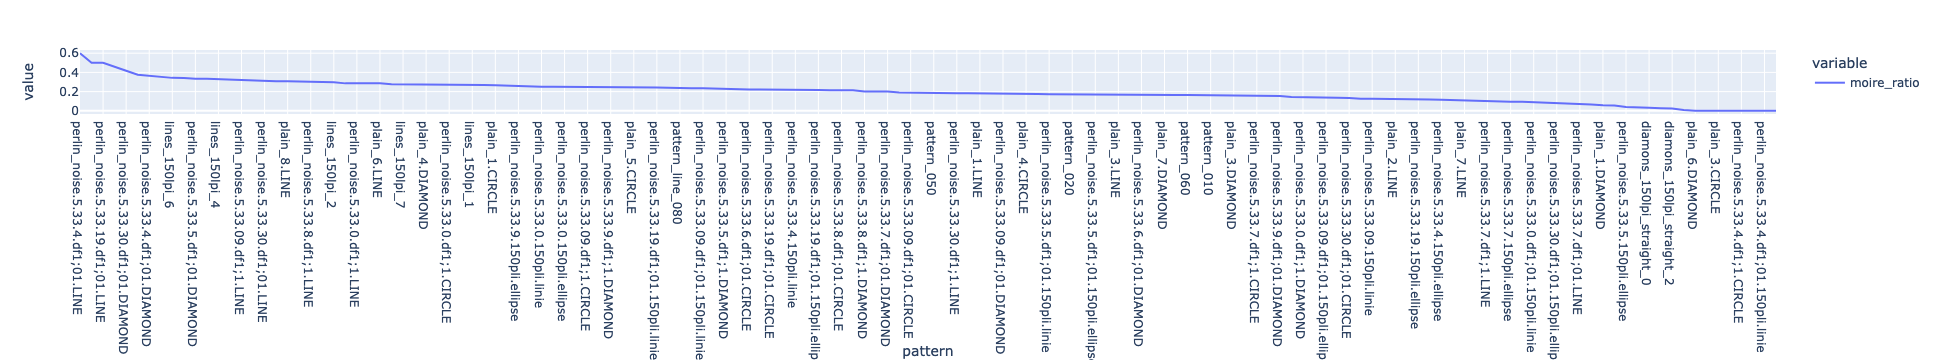

In [27]:
px.line(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False).moire_ratio
)

# Grouped by Feature

In [30]:
adjustments_per_mask = pd.merge(
    pd.read_sql(
        '''
            SELECT apm.* FROM mask m
            LEFT JOIN adjustment_per_mask apm 
            ON
                m.pdf_filename = apm.pdf_filename AND 
                m.job = apm.job  AND 
                m."type" = apm."type" AND 
                m.variant_name = apm.variant_name AND 
                m.idx = apm.idx AND 
                m.mask_id = apm.mask_id 
        ''',
        con
    ),
    pd.DataFrame(
        [
            (r['id'],r['labels'][0])
            for r in get_results_of_project(2)
            if 'id' in r
        ],
        columns=['mask_id','label']
    ),
    how='left',
    on='mask_id'
)

adjustments_per_mask = adjustments_per_mask.loc[
    pd.isna(adjustments_per_mask.label) == False
]

In [31]:
grouped_by_feature = adjustments_per_mask.loc[
    :,
    ['adjustment','label','pdf_filename']
].groupby(['adjustment','label']).count().unstack('label')
grouped_by_feature.columns = [c[1] for c in grouped_by_feature.columns]
grouped_by_feature.checked_moire.fillna(0, inplace=True)
grouped_by_feature.loc[:,'moire_ratio'] = grouped_by_feature.checked_moire / (grouped_by_feature.checked_moire + grouped_by_feature.checked_no_moire)

In [32]:
grouped_by_feature.sort_values('moire_ratio', ascending=False)

checked_moire  checked_no_moire  moire_ratio
adjustment                                                                  
rotation                                  573              2975     0.161499
trapezoidal_distortion                    159               830     0.160768
contract_centered                         158               845     0.157527
uniform_trapezoidal_distortion            146               800     0.154334
blow_up_centered                          148               819     0.153051
wave_deform                               140              1074     0.115321
stretch                                    51               463     0.099222
blow_up_region                             38               422     0.082609
contract_region                            35               406     0.079365
scale                                      21               366     0.054264

In [1]:
px.scatter(
    y=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'rotation'
    ].features.apply(lambda val: json.loads(val)['rotation_degree']),
    color=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'rotation'
    ].label
)

NameError: name 'px' is not defined

In [ ]:
adjustments_per_mask[
    adjustments_per_mask.adjustment == 'trapezoidal_distortion'
].features.apply(lambda val: json.loads(val)['trapezoidal_distortion_strength_1'])

In [ ]:
px.scatter(
    x=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'trapezoidal_distortion'
    ].features.apply(lambda val: json.loads(val)['trapezoidal_distortion_strength_1']),
    y=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'trapezoidal_distortion'
    ].features.apply(lambda val: json.loads(val)['trapezoidal_distortion_strength_2']),
    color=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'trapezoidal_distortion'
    ].label
)

In [ ]:
px.scatter(
    y=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'stretch'
    ].features.apply(lambda val: json.loads(val)['stretch_x']),
    color=adjustments_per_mask[
        adjustments_per_mask.adjustment == 'stretch'
    ].label
)